In [1]:
from gluoncv.data import VOCDetection

/home/wk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd

In [3]:
# typically we use 2007+2012 trainval splits for training data
# train_dataset = data.VOCDetection(root='./VOCdevkit/',splits=[(2007, 'trainval'), (2012, 'trainval')])
train_dataset = VOCDetection(root='./data/VOCdevkit/',splits=[(2007, 'trainval')])
# and use 2007 test as validation data
val_dataset = VOCDetection(root='./data/VOCdevkit/',splits=[(2007, 'test')])

print('Num of training images:', len(train_dataset))
print('Num of validation images:', len(val_dataset))

Num of training images: 5011
Num of validation images: 4952


In [4]:
train_image, train_label = train_dataset[0]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

image: (375, 500, 3)
bboxes: (5, 4) class ids: (5, 1)


In [5]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

ax = viz.plot_bbox(
    train_image.asnumpy(),
    bboxes,
    labels=cids,
    class_names=train_dataset.classes)
plt.show()

<Figure size 640x480 with 1 Axes>

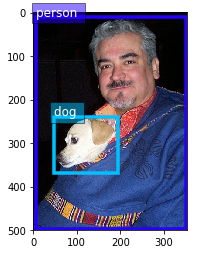

In [6]:
val_image, val_label = val_dataset[0]
bboxes = val_label[:, :4]
cids = val_label[:, 4:5]
ax = viz.plot_bbox(
    val_image.asnumpy(),
    bboxes,
    labels=cids,
    class_names=train_dataset.classes)
plt.show()

In [7]:
from gluoncv.data.transforms import presets
from gluoncv import utils
from mxnet import nd

In [8]:
width, height = 512, 512  # suppose we use 512 as base training size
train_transform = presets.ssd.SSDDefaultTrainTransform(width, height)
val_transform = presets.ssd.SSDDefaultValTransform(width, height)

In [9]:
utils.random.seed(233)  # fix seed in this tutorial

In [10]:
train_image2, train_label2 = train_transform(train_image, train_label)
print('tensor shape:', train_image2.shape)

tensor shape: (3, 512, 512)


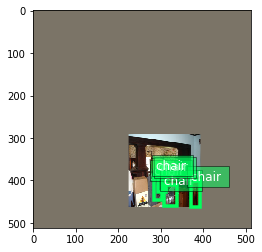

In [11]:
train_image2 = train_image2.transpose(
    (1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
train_image2 = (train_image2 * 255).clip(0, 255)
ax = viz.plot_bbox(train_image2.asnumpy(), train_label2[:, :4],
                   labels=train_label2[:, 4:5],
                   class_names=train_dataset.classes)
plt.show()

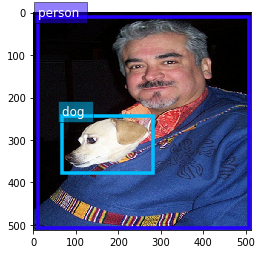

In [12]:
val_image2, val_label2 = val_transform(val_image, val_label)
val_image2 = val_image2.transpose(
    (1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
val_image2 = (val_image2 * 255).clip(0, 255)
ax = viz.plot_bbox(val_image2.clip(0, 255).asnumpy(), val_label2[:, :4],
                   labels=val_label2[:, 4:5],
                   class_names=train_dataset.classes)
plt.show()

In [13]:
from gluoncv.data.batchify import Tuple, Stack, Pad
from mxnet.gluon.data import DataLoader

batch_size = 2  # for tutorial, we use smaller batch-size
# you can make it larger(if your CPU has more cores) to accelerate data loading
num_workers = 0

# behavior of batchify_fn: stack images, and pad labels
batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
train_loader = DataLoader(
    train_dataset.transform(train_transform),
    batch_size,
    shuffle=True,
    batchify_fn=batchify_fn,
    last_batch='rollover',
    num_workers=num_workers)
val_loader = DataLoader(
    val_dataset.transform(val_transform),
    batch_size,
    shuffle=False,
    batchify_fn=batchify_fn,
    last_batch='keep',
    num_workers=num_workers)

for ib, batch in enumerate(train_loader):
    if ib > 3:
        break
    print('data:', batch[0].shape, 'label:', batch[1].shape)

data: (2, 3, 512, 512) label: (2, 2, 6)
data: (2, 3, 512, 512) label: (2, 6, 6)
data: (2, 3, 512, 512) label: (2, 4, 6)
data: (2, 3, 512, 512) label: (2, 6, 6)


In [14]:
from gluoncv import model_zoo
# net = model_zoo.get_model('ssd_300_vgg16_atrous_voc', pretrained_base=False)
net = model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained_base=False)
# print(net)

In [22]:
import mxnet as mx
x = mx.nd.zeros(shape=(1, 3, 512, 512))
net.initialize()
cids, scores, bboxes = net(x)

/home/wk/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'ssd0_mobilenet0_conv0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wk/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'ssd0_mobilenet0_batchnorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wk/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'ssd0_mobilenet0_batchnorm0_beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/wk/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'ssd0_mobilenet0_conv1_weight' is already initialized, ignoring. Set force_reinit=True to re-initiali

In [25]:
from mxnet import autograd
with autograd.train_mode():
    cls_preds, box_preds, anchors = net(x)

In [26]:
from mxnet import gluon
train_transform = presets.ssd.SSDDefaultTrainTransform(width, height, anchors)
batchify_fn = Tuple(Stack(), Stack(), Stack())
train_loader = DataLoader(
    train_dataset.transform(train_transform),
    batch_size,
    shuffle=True,
    batchify_fn=batchify_fn,
    last_batch='rollover',
    num_workers=num_workers)

In [27]:
ctx = mx.gpu(0)


In [29]:
from gluoncv.loss import SSDMultiBoxLoss
mbox_loss = SSDMultiBoxLoss()
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})

for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    print('data:', batch[0].shape)
    print('class targets:', batch[1].shape)
    print('box targets:', batch[2].shape)
#     batch.as_in_context(ctx)
    with autograd.record():
        cls_pred, box_pred, anchors = net(batch[0])
        sum_loss, cls_loss, box_loss = mbox_loss(
            cls_pred, box_pred, batch[1], batch[2])
        # some standard gluon training steps:
        # autograd.backward(sum_loss)
        # trainer.step(1)

data: (2, 3, 512, 512)
class targets: (2, 6132)
box targets: (2, 6132, 4)


MXNetError: [19:03:48] src/imperative/cached_op.cc:846: Check failed: inputs[i]->ctx() == default_ctx (cpu(0) vs. cpu_shared(0)) CachedOp requires all inputs to live on the same context. But data is on cpu_shared(0) while ssd0_mobilenet0_conv0_weight is on cpu(0)

Stack trace returned 10 entries:
[bt] (0) /home/wk/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x37f51a) [0x7fdd5358b51a]
[bt] (1) /home/wk/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x37fb51) [0x7fdd5358bb51]
[bt] (2) /home/wk/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x2b67aba) [0x7fdd55d73aba]
[bt] (3) /home/wk/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(MXInvokeCachedOp+0x61a) [0x7fdd55ca335a]
[bt] (4) /home/wk/anaconda3/lib/python3.6/site-packages/mxnet/libmxnet.so(MXInvokeCachedOpEx+0x4f) [0x7fdd55ca385f]
[bt] (5) /home/wk/anaconda3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7fdd9989fec0]
[bt] (6) /home/wk/anaconda3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7fdd9989f87d]
[bt] (7) /home/wk/anaconda3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7fdd99ab4e2e]
[bt] (8) /home/wk/anaconda3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12865) [0x7fdd99ab5865]
[bt] (9) /home/wk/anaconda3/bin/python(_PyObject_FastCallDict+0x8b) [0x55c2e6c1bd7b]

